# Exploratory Analysis

What are people talking about?

In [16]:
from utils import DTYPE, PARSE_DATES, PROVINCES, CONVERTERS
from tqdm.auto import tqdm
import pandas as pd
import glob

# f_name = "../data/processed_data/2020-02-15_2020-03-15.csv"
# total_df = pd.read_csv(f_name,header=0,dtype=DTYPE,converters=CONVERTERS,parse_dates=PARSE_DATES)
data_paths = glob.glob("../data/processed_data/*.csv")
frames = [pd.read_csv(f,header=0,dtype=DTYPE,converters=CONVERTERS,parse_dates=PARSE_DATES) for f in tqdm(data_paths)]
total_df = pd.concat(frames, axis=0, ignore_index=True).set_index("id").sort_values("created_at")
total_df = total_df[~total_df.index.duplicated()]

total_df["created_at"] = total_df["created_at"].dt.to_period("D").dt.to_timestamp('s')
print(len(total_df))
total_df.head()


349798


/Users/cameron/.local/share/virtualenvs/COVID-Child-Care-Twitter-vC7O4c45/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1091: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



,created_at,screen_name,source,clean_text,original_text,is_retweet,favorite_count,retweet_count,hashtags,urls,mentions,city,province,longitude,latitude
id,,,,,,,,,,,,,,,
1228469111451242497,2020-02-15,Transport_gc,Hootsuite Inc.,improve roadsafety canada many priority pilot ...,Improving #RoadSafety in #Canada is one of our...,False,9,1,"[RoadSafety, Canada, seatbelts]",[https://twitter.com/i/web/status/122846911145...,,NaN,NaN,-113.64258,60.10867
1228470050996113408,2020-02-15,4Everanimalz1,Twitter for iPad,improve roadsafety canada many priority pilot ...,Improving #RoadSafety in #Canada is one of our...,True,0,0,"[RoadSafety, Canada, seatbelts]",,[Transport_gc],Calgary,Alberta,-114.08529,51.05011
1228470466668564481,2020-02-15,Mom_ASDadvocate,Twitter for iPhone,student tcdsb would nice walk place know safe ...,"to me, a student in the TCDSB, this would be s...",True,0,0,,,[leahbanning],Toronto,Ontario,-79.41630,43.70011
1228470535530647552,2020-02-15,camille4change,Twitter for iPhone,student tcdsb would nice walk place know safe ...,"to me, a student in the TCDSB, this would be s...",True,0,0,,,[leahbanning],Hamilton,Ontario,-79.84963,43.25011
1228472099464810498,2020-02-15,DianneWatts4BC,Twitter for iPhone,still discuss pilot do already safety kid rid ...,Why is this still being discussed and piloted ...,False,27,4,,[https://twitter.com/i/web/status/122847209946...,,Surrey,British Columbia,-122.82509,49.10635


## How many and where?

what does the conversation look like?

In [17]:
import plotly.express as px
min_d,max_d = str(total_df["created_at"].min()).split()[0],str(total_df["created_at"].max()).split()[0]
counts = total_df.groupby(["created_at","province"]).count()["screen_name"].unstack().fillna(0)
# Get grand total for each date
counts = pd.DataFrame(counts.assign(Total=counts.sum(1)).stack()).reset_index().rename({0: "count"},axis=1)

counts = counts[counts["province"].isin(PROVINCES+["Total"])]
idx = pd.MultiIndex.from_product([counts['created_at'].unique(), counts['province'].unique()],names=['created_at', 'province'])
counts = counts.set_index(['created_at', 'province']).reindex(idx).reset_index().sort_values('created_at').fillna(0)
counts
args = {
    "x": "created_at",
    "y": "count",
    "color": "province",
    "line_shape": "vh",
    "title":  "Tweets Over Time",
    "template": "simple_white",
    "labels": {"count": "# Tweets", "created_at": "Date", "province": "Province"},
}

fig = px.line(counts,**args)
# fig.write_html(f"../visualizations/exploratory_analysis/{min_d}_{max_d}-tweets_over_time.html")
fig.show()

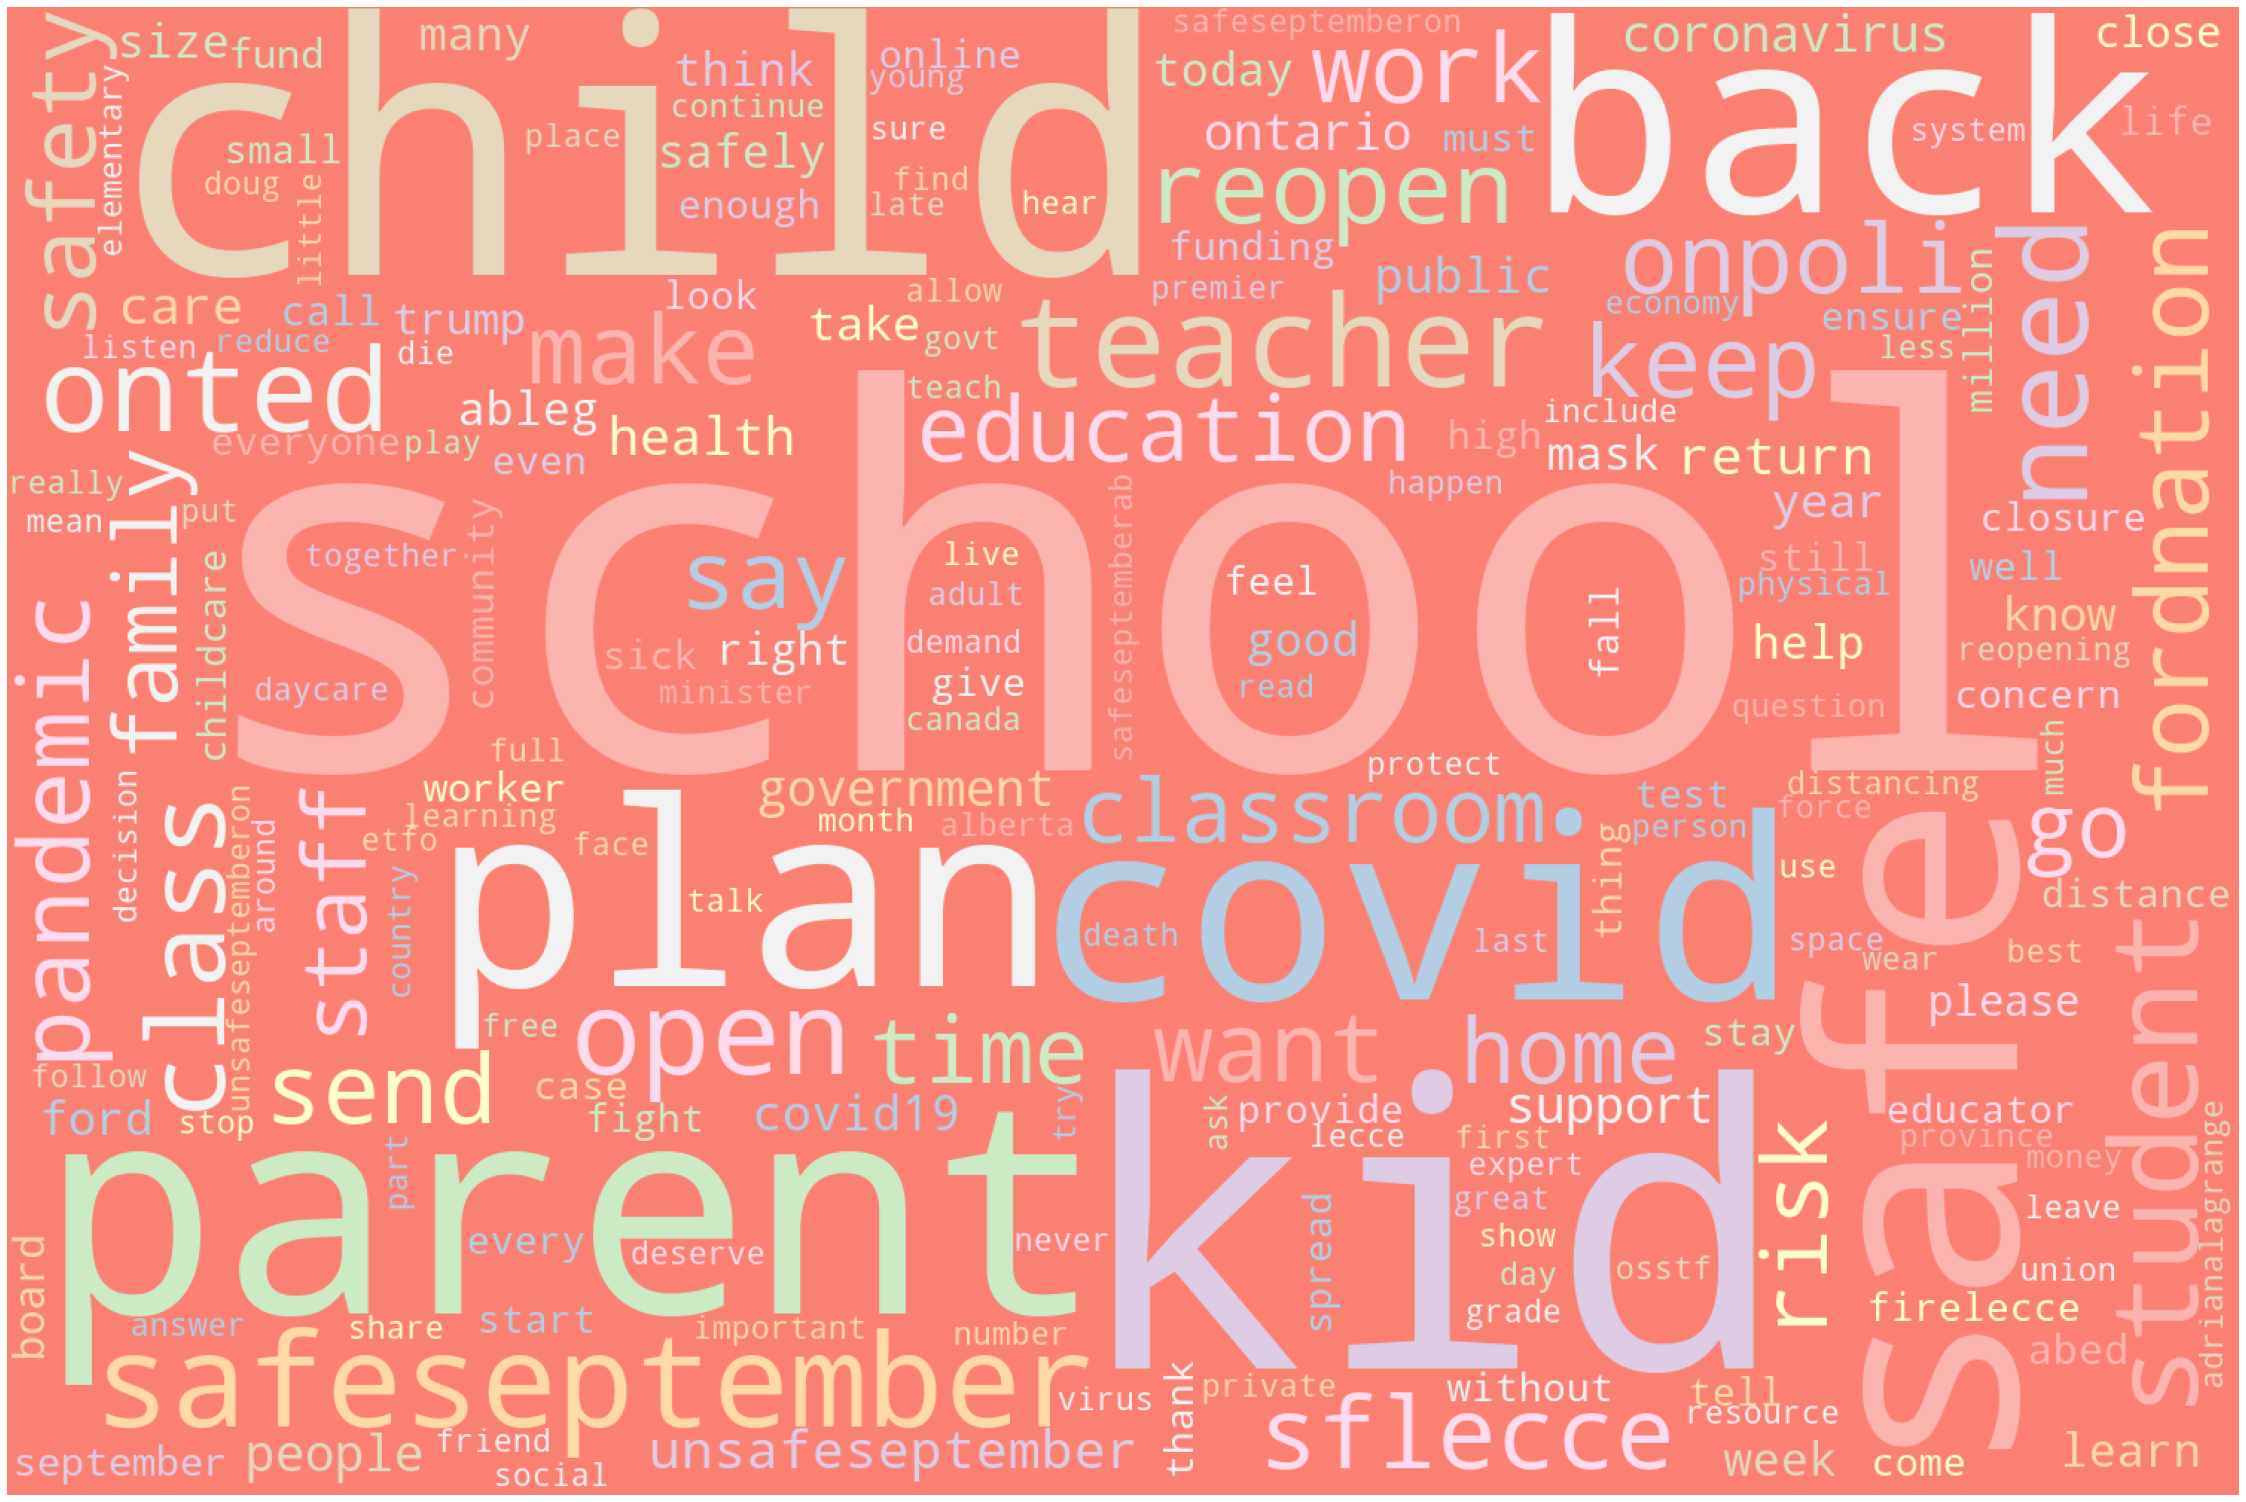

In [18]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

text = ' '.join(total_df[total_df.clean_text.notnull()]['clean_text'])
wordcloud = WordCloud(width=1500,
                      height=1000,
                      random_state=1,
                      background_color='salmon',
                      colormap='Pastel1',
                      collocations=False,
                      stopwords=STOPWORDS).generate(text)# Plot
# Set figure size
plt.figure(figsize=(40, 30))
# Display image
plt.imshow(wordcloud) 
# No axis details
plt.axis("off");
# plt.savefig(f"../visualizations/exploratory_analysis/{min_d}_{max_d}-wordcloud.png")